# Comparing Ensemble Methods on DeJong Dataset

Importing the necessary libraries, including the DLHub Client (currently at v5.0) and the necessary scikit-learn methods necessary to supplement the models available from DLHub.

In [1]:
import pandas as pd
from dlhub_sdk.client import DLHubClient
from sklearn.model_selection import cross_val_predict, ShuffleSplit
from sklearn.preprocessing import Imputer
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

Importing the featurized dataset used in the DeJong publication, then taking a subset of this for predictive modelling. For this test, we have 500 test points with access to 187 features in the feature space.

In [2]:
data = pd.read_pickle('./dejong_featurized_data.pkl')

x = data.drop(['material_id', 'volume', 'elastic_anisotropy', 'G_VRH', 
                    'K_VRH', 'poisson_ratio', 'structure', 'composition'], 1)

x = Imputer().fit_transform(x)
y = {'K': np.log(data['K_VRH']), 'G': np.log(data['G_VRH'])}
for ft in ['K', 'G']:
    for train_index, test_index in ShuffleSplit(n_splits=1, \
                                                test_size=500, train_size=500).split(x):
        x_test = x[test_index]
        y_test = y[ft][test_index]
    
print(x_test.shape)

(500, 187)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
DL = DLHubClient.login()
dejong_linreg = 'dejong_model_linreg'
dejong_ridgereg = 'dejong_model_ridgereg'
dejong_rforestreg = 'dejong_model_rforestreg'
dejong_etreereg = 'dejong_model_etreereg'
dejong_gboost = 'dejong_model_gboost'

In [4]:
author = 'mschwarting_anl/'
linreg_out = DL.run(name = author+dejong_linreg, inputs=x_test.tolist())[0]
ridgereg_out = DL.run(name = author+dejong_ridgereg, inputs=x_test.tolist())[0]
rforestreg_out = DL.run(name = author+dejong_rforestreg, inputs=x_test.tolist())[0]
etreereg_out = DL.run(name = author+dejong_etreereg, inputs=x_test.tolist())[0]
gboost_out = DL.run(name = author+dejong_gboost, inputs=x_test.tolist())[0]

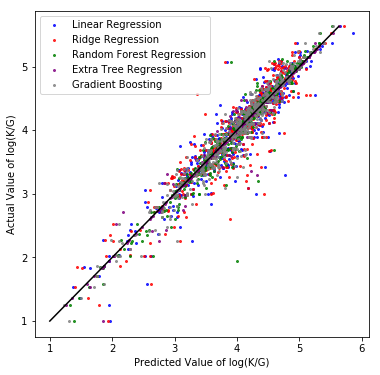

In [5]:
plt.figure(figsize=(6,6))
plt.plot([1,max(y_test)],[1,max(y_test)],color='black')
plt.scatter(linreg_out,y_test,label='Linear Regression',color='blue',alpha=0.8,s=4)
plt.scatter(ridgereg_out,y_test,label='Ridge Regression',color='red',alpha=0.8,s=4)
plt.scatter(rforestreg_out,y_test,label='Random Forest Regression',color='green',alpha=0.8,s=4)
plt.scatter(etreereg_out,y_test,label='Extra Tree Regression',color='purple',alpha=0.8,s=4)
plt.scatter(gboost_out,y_test,label='Gradient Boosting',color='gray',alpha=0.8,s=4)
plt.xlabel('Predicted Value of log(K/G)')
plt.ylabel('Actual Value of log(K/G)')
plt.legend()
plt.show()

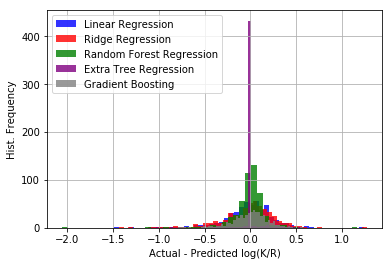

In [6]:
linreg_err = np.array(y_test)-np.array(linreg_out)
ridgereg_err = np.array(y_test)-np.array(ridgereg_out)
rforestreg_err = np.array(y_test)-np.array(rforestreg_out)
etreereg_err = np.array(y_test)-np.array(etreereg_out)
gboost_err = np.array(y_test)-np.array(gboost_out)

plt.figure()
plt.hist(linreg_err,50,alpha=0.8,label='Linear Regression',color='blue')
plt.hist(ridgereg_err,50,alpha=0.8,label='Ridge Regression',color='red')
plt.hist(rforestreg_err,50,alpha=0.8,label='Random Forest Regression',color='green')
plt.hist(etreereg_err,50,alpha=0.8,label='Extra Tree Regression',color='purple')
plt.hist(gboost_err,50,alpha=0.8,label='Gradient Boosting',color='gray')
plt.legend()
plt.xlabel('Actual - Predicted log(K/R)')
plt.ylabel('Hist. Frequency')
plt.grid(True)
plt.show()

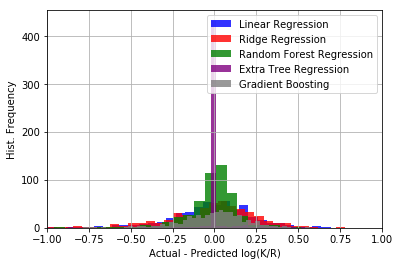

In [7]:
linreg_err = np.array(y_test)-np.array(linreg_out)
ridgereg_err = np.array(y_test)-np.array(ridgereg_out)
rforestreg_err = np.array(y_test)-np.array(rforestreg_out)
etreereg_err = np.array(y_test)-np.array(etreereg_out)
gboost_err = np.array(y_test)-np.array(gboost_out)

plt.figure()
plt.hist(linreg_err,50,alpha=0.8,label='Linear Regression',color='blue')
plt.hist(ridgereg_err,50,alpha=0.8,label='Ridge Regression',color='red')
plt.hist(rforestreg_err,50,alpha=0.8,label='Random Forest Regression',color='green')
plt.hist(etreereg_err,50,alpha=0.8,label='Extra Tree Regression',color='purple')
plt.hist(gboost_err,50,alpha=0.8,label='Gradient Boosting',color='gray')
plt.legend()
plt.xlabel('Actual - Predicted log(K/R)')
plt.ylabel('Hist. Frequency')
plt.grid(True)
plt.xlim([-1,1])
plt.show()

In [8]:
print('LinReg RMSE: '+str(round((mean_squared_error(y_test, linreg_out)**0.5),5)))
print('RidgeReg RMSE: '+str(round((mean_squared_error(y_test, ridgereg_out)**0.5),5)))
print('RForestReg RMSE: '+str(round((mean_squared_error(y_test, rforestreg_out)**0.5),5)))
print('ETreeReg RMSE: '+str(round((mean_squared_error(y_test, etreereg_out)**0.5),5)))
print('GBoost RMSE: '+str(round((mean_squared_error(y_test, gboost_out)**0.5),5)))

LinReg RMSE: 0.27464
RidgeReg RMSE: 0.29513
RForestReg RMSE: 0.18812
ETreeReg RMSE: 0.11224
GBoost RMSE: 0.18796


These results suggest that the Extra Trees Regressor method is performing best on this dataset.

Ensemble RMSE: 0.16553


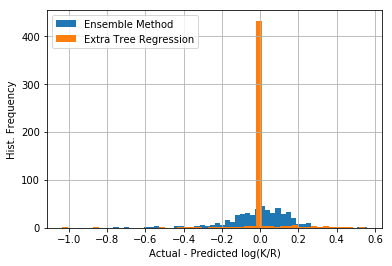

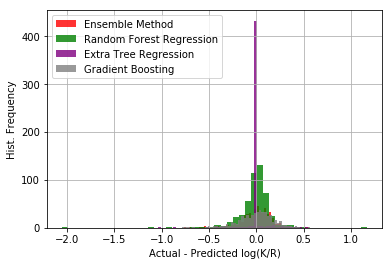

In [20]:
ensemble_reg = (np.array(gboost_out)+np.array(etreereg_out)+np.array(ridgereg_out))/3.0
ensemble_reg_err = np.array(y_test)-np.array(ensemble_reg)
print('Ensemble RMSE: '+str(round((mean_squared_error(y_test, ensemble_reg)**0.5),5)))

plt.figure()
plt.hist(ensemble_reg_err,50,label='Ensemble Method')
plt.hist(etreereg_err,50,label='Extra Tree Regression')
plt.grid(True)
plt.xlabel('Actual - Predicted log(K/R)')
plt.ylabel('Hist. Frequency')
plt.legend()
plt.show()

plt.figure()
plt.hist(ensemble_reg_err,50,alpha=0.8,label='Ensemble Method',color='red')
plt.hist(rforestreg_err,50,alpha=0.8,label='Random Forest Regression',color='green')
plt.hist(etreereg_err,50,alpha=0.8,label='Extra Tree Regression',color='purple')
plt.hist(gboost_err,50,alpha=0.8,label='Gradient Boosting',color='gray')
plt.xlabel('Actual - Predicted log(K/R)')
plt.ylabel('Hist. Frequency')
plt.grid(True)
plt.legend()
plt.show()